In [21]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import sys


# Data Preprocessing

In [22]:
df = pd.read_csv('BTC_1h_20250508_083303_historical.csv')
df['pct_change'] = df['close'].pct_change() * 100
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
df.set_index('timestamp', inplace=True)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Convertir à nouveau en DataFrame avec les bons noms de colonnes
df_scaled = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)
df_scaled.head()

,open,high,low,close,volume,pct_change
timestamp,,,,,,
2025-03-09 08:33:03.270,0.456119,0.446607,0.465469,0.460446,0.009459,NaN
2025-03-09 09:33:03.270,0.460469,0.444143,0.462079,0.451338,0.004050,0.340433
2025-03-09 10:33:03.270,0.451360,0.435582,0.444109,0.441654,0.023481,0.338360
2025-03-09 11:33:03.270,0.441595,0.423763,0.419155,0.412317,0.048111,0.269947
2025-03-09 12:33:03.270,0.412342,0.402422,0.417480,0.419867,0.030807,0.398394


In [23]:
# Clean Data
df['pct_change'] = df['pct_change'].fillna(0)

# Parameters Definitions

In [24]:
# Définition des paramètres
input_size = 6       # Utiliser toutes les caractéristiques disponibles
hidden_size = 64     # Nombre de neurones dans la couche cachée
output_size = 1      # Prédiction d'une seule valeur à la fois
num_layers = 2       # Augmenter le nombre de couches pour plus de capacité
batch_size = 16      # Utiliser un batch plus grand pour une meilleure stabilité
seq_length = 10      # Longueur de la séquence d'entrée
forecast_horizon = 5  # Nombre de pas de temps à prédire

# Model 

In [ ]:
# Classe modèle GRU 
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(GRUModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size  # Stocker la taille d'entrée
        self.output_size = output_size  # Stocker la taille de sortie
        
        # Couche GRU
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,  # Plus intuitif avec batch en première dimension
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Couche de sortie
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden=None):
        # Vérifier et corriger les dimensions si nécessaire
        if x.dim() > 3:
            # Si le tenseur a trop de dimensions, le corriger
            x = x.squeeze(0)  # Enlever la première dimension supplémentaire si elle existe
        
        # Si aucun état caché n'est fourni, l'initialiser
        if hidden is None:
            batch_size = x.size(0)
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        
        # Passage à travers la couche GRU
        out, hidden = self.gru(x, hidden)
        
        # Appliquer la couche fully connected uniquement à la dernière sortie temporelle
        predictions = self.fc(out)
        
        return predictions, hidden
    
    def predict_sequence(self, initial_sequence, steps=1, target_column_idx=None):
        """Prédit les 'steps' valeurs futures à partir d'une séquence initiale"""
        self.eval()  # Passer en mode évaluation
        
        with torch.no_grad():
            # S'assurer que la séquence est au bon format (batch_size, seq_length, features)
            current_seq = initial_sequence.clone().detach()
            
            # Vérifier et corriger les dimensions
            if current_seq.dim() > 3:
                current_seq = current_seq.squeeze(0)
            elif current_seq.dim() < 3:
                # Si la dimension est trop petite, ajouter une dimension de batch
                current_seq = current_seq.unsqueeze(0)
            
            # Obtenir les dimensions importantes
            batch_size, seq_len, feature_size = current_seq.size()
            
            # Liste pour stocker les prédictions
            predictions = []
            
            hidden = None
            
            for _ in range(steps):
                # Faire une prédiction
                output, hidden = self(current_seq, hidden)
                
                # Obtenir la dernière prédiction
                last_pred = output[:, -1:, :]
                predictions.append(last_pred)
                
                # Créer un nouvel input pour la prochaine prédiction
                # On crée un tenseur de même taille que l'entrée originale
                if self.input_size > self.output_size:
                    # Si l'entrée a plus de caractéristiques que la sortie,
                    # on doit étendre la prédiction à toutes les caractéristiques
                    
                    # Créer un tenseur de zéros
                    next_input = torch.zeros(batch_size, 1, self.input_size, device=current_seq.device)
                    
                    # Si l'index de la colonne cible est fourni, on utilise celui-ci
                    # Sinon, on suppose que c'est la dernière caractéristique
                    col_idx = target_column_idx if target_column_idx is not None else -1
                    
                    # Placer la prédiction à la position appropriée
                    next_input[:, :, col_idx] = last_pred.squeeze(-1)
                else:
                    # Si la sortie a la même dimension que l'entrée, on peut utiliser directement
                    next_input = last_pred
                
                # Mettre à jour la séquence pour la prochaine prédiction
                # On supprime la première entrée et on ajoute la prédiction
                current_seq = torch.cat([current_seq[:, 1:, :], next_input], dim=1)
            
            # Concaténer toutes les prédictions
            return torch.cat(predictions, dim=1)

# Préparation des données
def prepare_data(df, seq_length, target_col='pct_change'):
    """Prépare les données pour l'entraînement du modèle GRU"""
    # Normalisation des données
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df.values)
    
    # Création des séquences X et des cibles y
    X, y = [], []
    
    for i in range(len(df) - seq_length):
        X.append(scaled_data[i:i+seq_length])
        y.append(scaled_data[i+seq_length, df.columns.get_loc(target_col)])
    
    # Conversion en tensors
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y)).view(-1, 1)
    
    return X, y, scaler

# Préparation des données pour l'entraînement
X, y, scaler = prepare_data(df, seq_length)

# Séparation en ensembles d'entraînement et de test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Création de DataLoader pour un traitement par batch
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialisation du modèle
model = GRUModel(input_size, hidden_size, output_size, num_layers)

# Définition de l'optimiseur et de la fonction de perte
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Nombre d'époques d'entraînement
num_epochs = 50

# Pour le suivi des performances
train_losses = []
test_losses = []

# Boucle d'entraînement
for epoch in range(num_epochs):
    model.train()  # Passer en mode entraînement
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions, _ = model(batch_X)
        loss = loss_fn(predictions[:, -1, :], batch_y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    
    # Validation sur l'ensemble de test
    model.eval()  # Passer en mode évaluation
    with torch.no_grad():
        test_loss = 0
        for batch_X, batch_y in test_loader:
            predictions, _ = model(batch_X)
            test_loss += loss_fn(predictions[:, -1, :], batch_y).item()
        
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
    
    # Affichage de la progression
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Visualisation des résultats d'entraînement
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution des pertes pendant l\'entraînement')
plt.legend()
plt.grid(True)
plt.show()

Epoch [5/50], Train Loss: 0.0052, Test Loss: 0.0026
Epoch [10/50], Train Loss: 0.0049, Test Loss: 0.0021
Epoch [15/50], Train Loss: 0.0048, Test Loss: 0.0019
Epoch [20/50], Train Loss: 0.0048, Test Loss: 0.0018
Epoch [25/50], Train Loss: 0.0047, Test Loss: 0.0018
Epoch [30/50], Train Loss: 0.0047, Test Loss: 0.0017
Epoch [35/50], Train Loss: 0.0047, Test Loss: 0.0017
Epoch [40/50], Train Loss: 0.0047, Test Loss: 0.0017
Epoch [45/50], Train Loss: 0.0047, Test Loss: 0.0018
Epoch [50/50], Train Loss: 0.0047, Test Loss: 0.0017


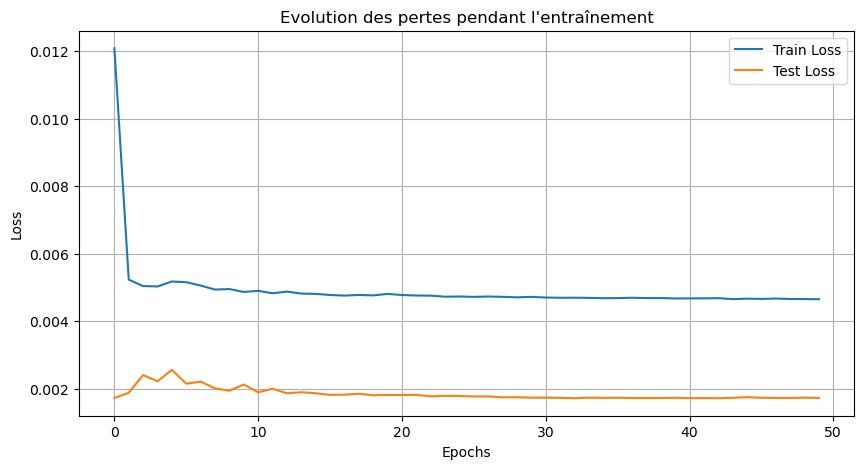


Prédictions des 5 prochains pct_change:
t+1: 0.0764%
t+2: 0.2488%
t+3: 0.3428%
t+4: 0.3871%
t+5: 0.4222%


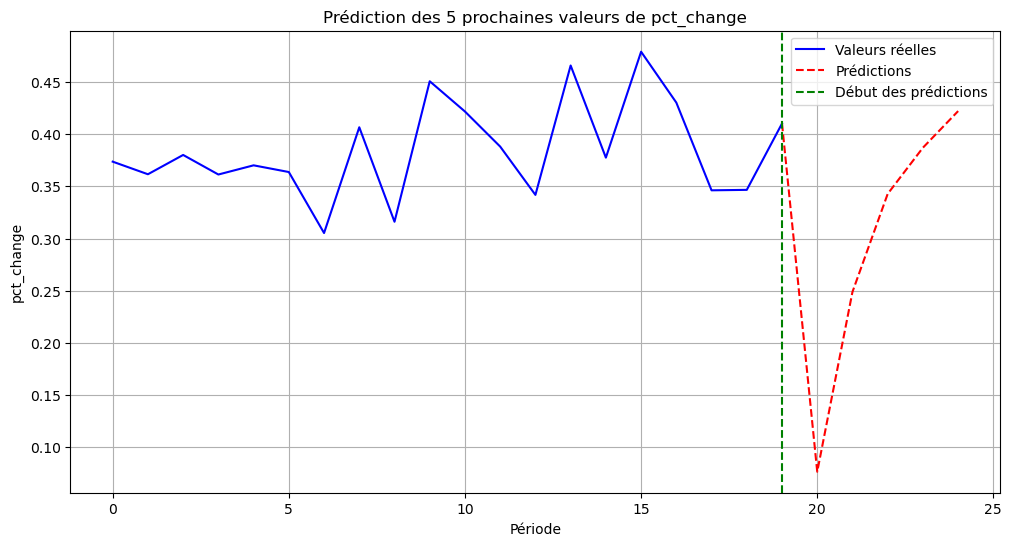

In [ ]:
# Prédiction des 5 prochaines valeurs de pct_change
def predict_future(model, last_sequence, steps=5):
    """Prédit les N prochaines valeurs à partir des dernières données connues"""
    target_col_idx = df.columns.get_loc('pct_change')
    
    # Faire la prédiction avec l'index de la colonne cible
    future_predictions = model.predict_sequence(last_sequence, steps, target_col_idx)
    
    # Retourner les prédictions sous forme de numpy array
    return future_predictions.squeeze().numpy()

# Récupérer la dernière séquence de données
last_known_sequence = X_test[-1:].clone()  # Prendre la dernière séquence du test set (déjà avec dimension batch)

# Prédire les 5 prochaines valeurs
target_col_idx = df.columns.get_loc('pct_change')
future_pct_changes_scaled = predict_future(model, last_known_sequence, forecast_horizon)

# Inverser la normalisation pour obtenir les vraies valeurs
# Créer un tableau pour les prédictions dénormalisées
future_pct_changes = np.zeros(len(future_pct_changes_scaled))

# Pour chaque prédiction, créer un tableau complet puis le dénormaliser
for i in range(len(future_pct_changes_scaled)):
    # Créer un tableau de zéros pour une observation complète
    temp_array = np.zeros((1, df.shape[1]))
    # Assigner la valeur prédite à la colonne cible
    temp_array[0, target_col_idx] = future_pct_changes_scaled[i]
    # Dénormaliser et extraire seulement la colonne cible
    future_pct_changes[i] = scaler.inverse_transform(temp_array)[0, target_col_idx]

# Afficher les prédictions
print("\nPrédictions des 5 prochains pct_change:")
for i, val in enumerate(future_pct_changes):
    print(f"t+{i+1}: {val:.4f}%")

# Visualiser les prédictions futures
plt.figure(figsize=(12, 6))
# Extraire les dernières valeurs réelles pour comparer
last_real_values = y_test[-20:].numpy().flatten()
time_points = np.arange(len(last_real_values) + len(future_pct_changes))

# Tracer les valeurs réelles
plt.plot(time_points[:len(last_real_values)], last_real_values, 'b-', label='Valeurs réelles')

# Tracer les prédictions futures
plt.plot(time_points[len(last_real_values)-1:], np.append(last_real_values[-1], future_pct_changes), 'r--', label='Prédictions')

# Ajouter une ligne verticale pour séparer historique et prédictions
plt.axvline(x=len(last_real_values)-1, color='g', linestyle='--', label='Début des prédictions')

plt.xlabel('Période')
plt.ylabel('pct_change')
plt.title('Prédiction des 5 prochaines valeurs de pct_change')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
print(future_pct_changes)

[0.07644762 0.24882457 0.34281199 0.38706187 0.42217557]


In [28]:
df.tail()

,open,high,low,close,volume,pct_change
timestamp,,,,,,
2025-05-08 02:33:03.270,97824.0,98876.0,97824.0,98684.0,1984.78021,0.878099
2025-05-08 03:33:03.270,98684.0,99241.0,98544.0,99156.0,1619.88797,0.478294
2025-05-08 04:33:03.270,99155.0,99400.0,98927.0,98947.0,2203.95421,-0.210779
2025-05-08 05:33:03.270,98948.0,99136.0,98737.0,98742.0,885.63796,-0.207182
2025-05-08 06:33:03.270,98742.0,99052.0,98735.0,99052.0,593.31749,0.313949
